<a href="https://colab.research.google.com/github/Joao-Girotto/Desafio-Python-Marvel/blob/joao/Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalações

In [ ]:
!pip install dotenv

## Importações

In [ ]:
import requests
import hashlib
import os
import time
import pandas as pd
import sqlite3
import json
from dotenv import load_dotenv
from google.colab import userdata

## Pegando as chaves

In [ ]:
# load_dotenv()
# PUBLIC_KEY = os.getenv("Public_Key")
# PRIVATE_KEY = os.getenv("Private_Key")

PRIVATE_KEY = userdata.get("Private_Key")
PUBLIC_KEY = userdata.get("Public_Key")


## Endpoints e Parâmetros

In [ ]:
ts = str(time.time())
to_hash = ts + PRIVATE_KEY + PUBLIC_KEY
hash_md5 = hashlib.md5(to_hash.encode()).hexdigest()

end1 = "https://gateway.marvel.com/v1/public/characters"
end2 = "https://gateway.marvel.com/v1/public/comics"
end3 = "https://gateway.marvel.com/v1/public/series"


params = {
    "apikey": PUBLIC_KEY,
    "ts": ts,
    "hash": hash_md5,
    "limit": 100
}

## Requisição

In [ ]:
array = []
offset = 0

while offset <= 1564:
  params['offset'] = offset
  response = requests.get(end1, params=params)
  data = response.json()
  array.extend(data['data']['results']) # Adiciona os resultados à lista array
  offset += 100
  print(offset)
  print(response.status_code)

# Depois do loop, crie o DataFrame a partir da lista array
df = pd.DataFrame(array)



## Exibição

In [ ]:
df = df[['name', 'id', 'description', 'comics']]
df['comics_available'] = df['comics'].apply(lambda x: x.get('available'))
df['comics_returned'] = df['comics'].apply(lambda x: x.get('returned'))
df['comics'] = df['comics'].apply(lambda x: json.dumps(x))
con = sqlite3.connect('Marvel.db')
df.to_sql("characters", con, if_exists="replace", index=False)
con.close()

## Consultando o Banco de Dados

In [82]:
con2 = sqlite3.connect('Marvel.db')
df2 = pd.read_sql_query("SELECT id, name, description, comics_available, comics_returned FROM characters", con2)
df3 = pd.read_sql_query("SELECT id, name, description, comics_available, comics_returned FROM characters WHERE comics_available = comics_returned", con2)
df4 = pd.read_sql_query("SELECT id, name FROM characters", con2)
query = """
SELECT SUBSTR(name, 1, 1) AS letra_inicial, COUNT(*) AS total_por_letra
FROM characters
GROUP BY letra_inicial
ORDER BY letra_inicial;
"""
contagem_por_letra = pd.read_sql_query(query, con2)
con2.close()

## Resultados da primeira consulta, demonstrando todos os dados

In [ ]:
df2

## Resultado da segunda consulta, onde retorna todos os personagens que tem todos seus quadrinhos disponíveis

In [ ]:
df3

In [ ]:

def verifica_primeiras_letras(nome_completo):
  """Verifica se o nome e o sobrenome de um nome completo começam com a mesma letra."""
  partes_nome = nome_completo.split()
  if len(partes_nome) >= 2:
    nome = partes_nome[0]
    sobrenome = partes_nome[-1] # Pega a última parte como sobrenome
    if nome and sobrenome: # Verifica se nome e sobrenome não são vazios
      return nome[0].lower() == sobrenome[0].lower()
  return False # Retorna False se não for possível verificar (nome curto ou vazio)

# Aplica a função à coluna 'name' e cria uma nova coluna booleana
df['nome_sobrenome'] = df2['name'].apply(verifica_primeiras_letras)

# Para ver os personagens que atendem à condição
df_mesma_letra = df[df['nome_sobrenome']]
df_mesma_letra[['name', 'nome_sobrenome']]

## Resultado da soma

In [88]:
contagem_por_letra

,letra_inicial,total_por_letra
0,3,1
1,A,84
2,B,101
3,C,104
4,D,80
5,E,35
6,F,38
7,G,63
8,H,74
9,I,41


## Gráfico

<Axes: xlabel='letra_inicial'>

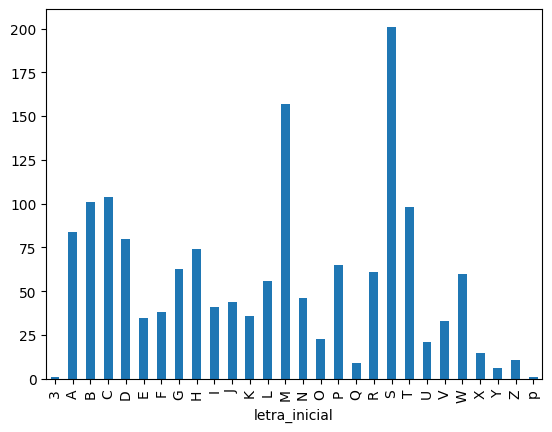

In [87]:
contagem_por_letra.plot.bar(x='letra_inicial', y='total_por_letra', legend=False)